<a href="https://colab.research.google.com/github/MatRitchie/Bachelor/blob/main/Preprosessing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [2]:
!pip install vec2graph

In [3]:
#@title Importing libraries

import pandas as pd
import numpy as np
from typing import Dict, Iterable, List, Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import matplotlib.cm as cm

from collections import Counter
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from gensim import models
from gensim.models.word2vec import Text8Corpus

import re
import sys
import string

import nltk
nltk.download('punkt')
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from vec2graph import visualize

from subprocess import check_output

from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

%matplotlib inline
import os
import seaborn as sns
sns.set_style("darkgrid")

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#@title Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#@title Loading dataset
#Features are renamed, and the first row is skipped
feature_names = ['Artist', 'Title','Lyric']
my_dataset = pd.read_csv('/content/gdrive/My Drive/Kaggle/LYRICS_DATASET.csv', header=None, skiprows=1, names = feature_names)

my_dataset.head()

'''
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d leadbest/googlenewsvectorsnegative300

#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip
'''

'\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "/content/gdrive/My Drive/Kaggle"\n# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive\n\n#changing the working directory\n%cd /content/gdrive/My Drive/Kaggle\n!kaggle datasets download -d leadbest/googlenewsvectorsnegative300\n\n#unzipping the zip files and deleting the zip files\n!unzip \\*.zip  && rm *.zip\n'

Cleaning of the dataset 

In [6]:
#@title Cleaning of dataset 
#Cleaning of dataset(needs to be updated)
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = s.replace(",","")
    s = s.replace(".","")
    s = s.replace('(demo)',"")
    s = s.replace("(new song)","")
    s = s.replace("(acoustic)","")
    s = s.replace("(cover)","")
    s = s.replace("(arctic monkeys cover)","")
    s = s.replace("(remix)","")
    s = s.replace("(argentum remix)","")
    s = s.replace("(rick ross remix)","")
    s = s.replace("(latin remix)","")
    s = s.replace("(maya jane coles remix)","")
    s = s.replace("(sir spyro remix)","")
    s = s.replace("(live)","")
    s = s.replace("(live from dublin academy)","")
    s = s.replace("(live from the late late show)","")
    s = s.replace("(bbc radio 1 live lounge)","")
    s = s.replace("(live at sofar sounds)","")
    s = s.replace("(live at windmill lane studios)","")
    s = s.replace("(live at the live room)","")
    s = s.replace("(poem)","")
    s = s.replace("[essay]","")
    s = re.sub('[!@#$+()/&?\´\-\'\’\"]', '', s)
    return s

my_dataset['Title'] = [cleaning(s) for s in my_dataset['Title']]
my_dataset['Lyric'] = [cleaning(s) for s in my_dataset['Lyric']]

my_dataset.head()

,Artist,Title,Lyric
0,Phoebe Bridgers,motion sickness,i hate you for what you did and i miss you li...
1,Phoebe Bridgers,killer,sometimes i think im a killer i scared you in...
2,Phoebe Bridgers,georgia,georgia georgia i love your son and when he g...
3,Phoebe Bridgers,kyoto,day off in kyoto got bored at the temple look...
4,Phoebe Bridgers,would you rather,playing would you rather when it comes to fir...


In [7]:
#@title Checking if title is in lyric

def procent_title_in_lyric(row):
  procentage = 0
  if row['Title'] in row['Lyric']:
      procentage = 100 
  else:
    token_lyc = nltk.word_tokenize(row['Lyric'])
    token_tit = nltk.word_tokenize(row['Title'])
    count = 0
    for token in token_tit:
      if token in token_lyc:
        count += 1
    procentage = count/len(token_tit) * 100 
  return procentage

def get_procent_of(dataset, percent):
  list_p = dataset.Procentage.tolist()
  occu = list_p.count(percent)
  percentage = (occu / dataset.shape[0] * 100)
  print('Procentage of songs where {0} % of title is part of lyric: {1}'.format(percent,percentage))
 

my_dataset['Procentage'] = my_dataset.apply (lambda row: procent_title_in_lyric(row), axis=1)

get_procent_of(my_dataset, 100)
get_procent_of(my_dataset, 0)


Procentage of songs where 100 % of title is part of lyric: 82.42074927953891
Procentage of songs where 0 % of title is part of lyric: 7.780979827089338


Generel statistics on dataset 

This is done to get some more information about the dataset, and how it is composed. 

Average number of charecters in Title is: 13.870317002881844
Average number of charecters in Lyric is: 1206.5446685878962
Average number of words in Title is: 2.7348703170028816
Average number of words in Lyric is: 249.2420749279539


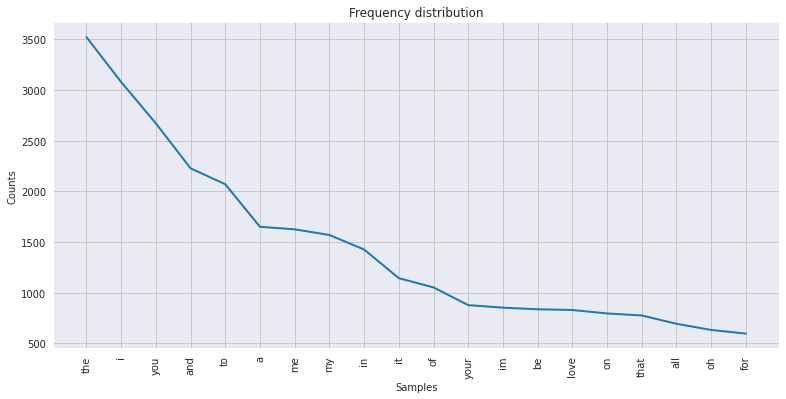

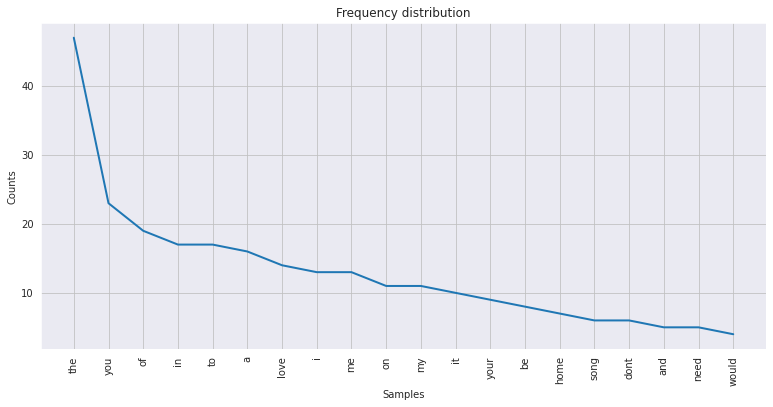

There are 2851 unique words, which is 3.282104414896679% of the total words
There are 406 unique words, which is 42.64705882352941% of the total words


In [8]:
#@title General statistics on dataset

#maybe I also want to find min/max 

#finding average amount of words and charecters 
def AverageChar(dataset, column):
  all_char = [len(s) for s in dataset[column]]
  avg_char = sum(all_char) / len(dataset)
  print('Average number of charecters in {0} is: {1}'.format(column, avg_char))

def AverageWords(dataset, column):
  all_words = [len(s.split()) for s in dataset[column]]
  avg_words = sum(all_words) / len(dataset)
  print('Average number of words in {0} is: {1}'.format(column, avg_words))

AverageChar(my_dataset, 'Title')
AverageChar(my_dataset, 'Lyric')
AverageWords(my_dataset, 'Title')
AverageWords(my_dataset, 'Lyric')


#Finding the most frequent words (Stopwords are not excluded)
def Freqwords(top_freq,column):
  txt = column.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
  words = nltk.tokenize.word_tokenize(txt)
  fdist = FreqDist(words)
  frequent_words = fdist.most_common(top_freq)
  plt.figure(figsize=(13,6))
  plt.title('Frequency distribution')
  fdist.plot(top_freq)
  #print('The {0} most frequent words are {1}'.format(top_freq, frequent_words))

Freqwords(20,  my_dataset.Lyric)
Freqwords(20, my_dataset.Title)

#Finding the unique words 
def UqWords(column):
  txt = column.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
  words = nltk.tokenize.word_tokenize(txt)
  fdist = FreqDist(words)
  unique_words = fdist.hapaxes()
  procent_unique_words = len(unique_words) / len(words) * 100
  print('There are {0} unique words, which is {1}% of the total words'.format(len(unique_words), procent_unique_words))
 
UqWords(my_dataset.Lyric)
UqWords(my_dataset.Title)

Word embedder

In this I use word2ved as a word embedder in order to get word vectors.

In [11]:
#@title word embedder

#The data needs to be tokenized 
my_dataset['Lyric_tok'] = [nltk.tokenize.word_tokenize(s) for s in my_dataset['Lyric']]

#The word2vec takes as input a list of sentences list of list 
sentences = list()
for lyric in my_dataset['Lyric_tok']:
     li = list(lyric)
     sentences.append(li)	

#Because of the size of the dataset, and the mincount is set to 5, alot of the words will not be accounted for in title..
#This word2vec uses skip-gram 

#Make model
model = word2vec.Word2Vec(min_count=5, window=4, size=300, sg=1)
#Build vocab
model.build_vocab(sentences, progress_per=10000)

#Train
model.train(sentences, total_examples=model.corpus_count, epochs=5, report_delay=1)

#Loading a pretrained model
pre_model = models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Kaggle/GoogleNews-vectors-negative300.bin', binary=True)
model2 = word2vec.Word2Vec(min_count=5, window=4, size=300, sg=1)
model2.build_vocab(sentences, progress_per=10000)
model2.intersect_word2vec_format("/content/gdrive/My Drive/Kaggle/GoogleNews-vectors-negative300.bin", binary=True)
model2.train(sentences, total_examples=model.corpus_count, epochs=model2.iter)

INFO - 18:38:02: collecting all words and their counts
INFO - 18:38:02: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:38:02: collected 6018 word types from a corpus of 86865 raw words and 347 sentences
INFO - 18:38:02: Loading a fresh vocabulary
INFO - 18:38:02: effective_min_count=5 retains 1492 unique words (24% of original 6018, drops 4526)
INFO - 18:38:02: effective_min_count=5 leaves 79621 word corpus (91% of original 86865, drops 7244)
INFO - 18:38:02: deleting the raw counts dictionary of 6018 items
INFO - 18:38:02: sample=0.001 downsamples 72 most-common words
INFO - 18:38:02: downsampling leaves estimated 54033 word corpus (67.9% of prior 79621)
INFO - 18:38:03: estimated required memory for 1492 words and 300 dimensions: 4326800 bytes
INFO - 18:38:03: resetting layer weights
INFO - 18:38:03: training model with 3 workers on 1492 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=4
INFO - 18:38:03: worker thread finished; 

(270357, 434325)

In [ ]:
#@title similarity of words
# Similar word for king
#model.wv.similar_by_word(‘king’)

# Distance between two words
#model.wv.distance(‘king’,’queen’)

TSN-visualizsation 

This is done in order to get a visual representation of the dataset.

"t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. It was developed by Laurens van der Maatens and Geoffrey Hinton in 2008."



WARNING - 19:39:05: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 19:39:05: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 19:39:05: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value fo

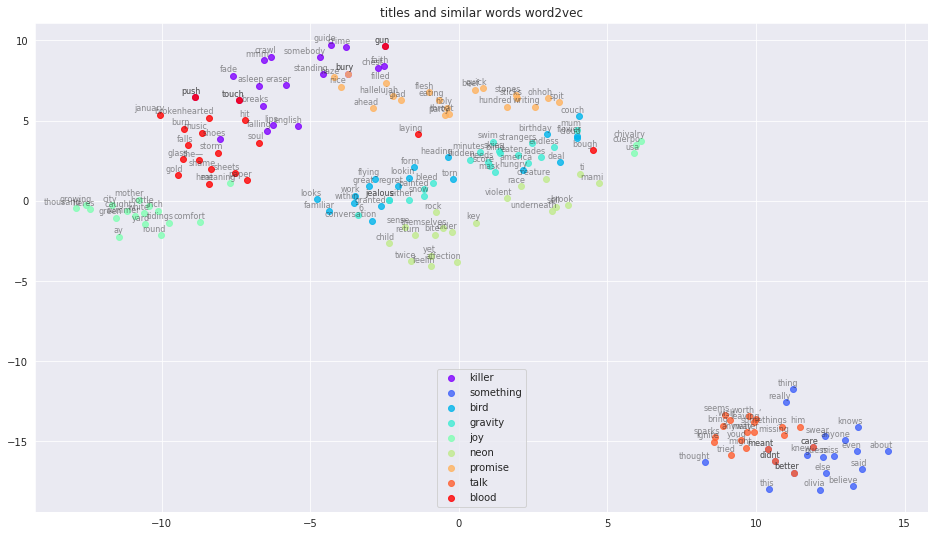

WARNING - 19:39:10: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 19:39:10: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 19:39:10: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value fo

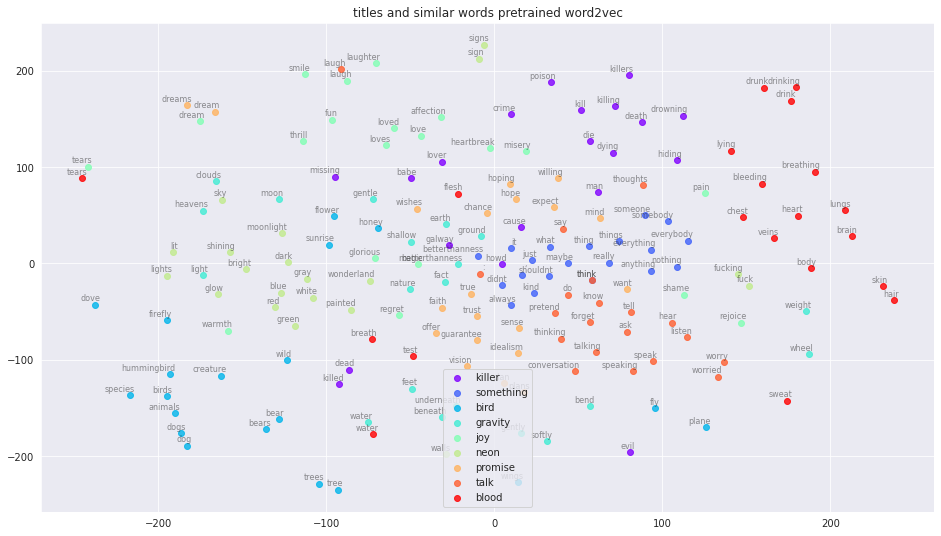

In [32]:
#@title tsn visulization

'''
The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. 
It then tries to optimize these two similarity measures using a cost function. 

1)
Meauser similarities between points in high dimensional space
Gaussian distribution around datapoint 

2)
Student t-distribution in the lower dimensional space 

3)
We want probabilities from low dimensional space to reflect those of the high dimensional space

source:
https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
'''

#These are all sing titles
keys = ['killer', 'something', 'bird', 'gravity', 'joy', 'neon', 'promise', 'talk', 'blood']


def get_embedding_cluster(keys, model):
  embedding_clusters = []
  word_clusters = []
  for word in keys:
      words = []      #Words similar to key
      embeddings = [] #Embedded word similar to key
      for similar_word, _ in model.most_similar(word, topn=20):
          words.append(similar_word)
          embeddings.append(model[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)
  
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  
  return word_clusters, embeddings_en_2d    



def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.8, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=8)
    plt.title(title)
    plt.show()

#Build model 
tsne_model_en_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)

#Word2vec trained only on lyrics 
word_clust1, embeddings1 = get_embedding_cluster(keys, model)
tsne_plot_similar_words('titles and similar words word2vec', keys, embeddings1, word_clust1)

#Pretrained model 
word_clust2, embeddings2 = get_embedding_cluster(keys, model2)
tsne_plot_similar_words('titles and similar words pretrained word2vec', keys, embeddings2, word_clust2)


In [9]:
#@title Splitting dataset

#1) need to split dataset into train, cross-validation set(development, dev), testing set 
'''
Build model on training set, optimize hyperparameters on development set, evaluate on testing set 
%60 - train
%20 - develop
%20 - test
Using features we want to predict labels. In this case using lyrics we want to predict the title, 
therefore the lyrics are the feature and the title is the label.
'''
#Splitting into train, test, dev
x_train, x_test = train_test_split (my_dataset, test_size=0.2, train_size=0.8 )
x_train, x_dev = train_test_split(x_train,test_size = 0.25, train_size =0.75)

#making individual .csv files for each of the datasets
x_train.to_csv('/content/gdrive/My Drive/Kaggle/LYRICS_DATASET_train.csv',index=False)
x_dev.to_csv('/content/gdrive/My Drive/Kaggle/LYRICS_DATASET_dev.csv',index=False)
x_test.to_csv('/content/gdrive/My Drive/Kaggle/LYRICS_DATASET_test.csv',index=False)

x_train.head()


,Artist,Title,Lyric,Procentage
150,Adam Melchor,calm forward,bugs will always bite me needles will never fr...,100.0
172,Hozier,nina cried power,its not the waking its the rising it is the g...,100.0
94,Issac Gracie,​reverie,hey babe what do you expect me to say i could...,0.0
297,Ed Sheeran,little lady,listen little lady this is just the worst way...,100.0
46,John Mayer,emoji of a wave,oh honey you dont have to try so hard to hurt...,50.0
